# Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Data Loading and Preprocessing

In [3]:
# read
df = pd.read_csv("/content/Picrosirius_WB_AllParams.csv")
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation
0,46_MXD_WB_L1,7.5,62.8,0.94,127.1,105,692,0.59,0.5211,0.43,152.0
1,46_MXD_WB_L1_2,6.8,51.5,0.95,119.8,41,454,0.66,0.6196,0.37,141.7
2,46_MXD_WB_L2,7.7,69.2,0.96,56.8,50,541,0.71,0.4178,0.43,27.1
3,46_MXD_WB_L2_2,7.4,65.4,0.93,133.0,248,946,0.77,0.7035,0.50,146.8
4,46_MXD_WB_R1,6.7,56.7,0.94,124.9,51,502,0.60,0.4512,0.37,144.8


In [4]:
# convert from pixels to microns
conversion_factor = 0.124 # ~0.124 µm/pixel

df["Length"] = df["Length"] * conversion_factor
df["Width"] = df["Width"] * conversion_factor
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation
0,46_MXD_WB_L1,0.9300,7.7872,0.94,127.1,105,692,0.59,0.5211,0.43,152.0
1,46_MXD_WB_L1_2,0.8432,6.3860,0.95,119.8,41,454,0.66,0.6196,0.37,141.7
2,46_MXD_WB_L2,0.9548,8.5808,0.96,56.8,50,541,0.71,0.4178,0.43,27.1
3,46_MXD_WB_L2_2,0.9176,8.1096,0.93,133.0,248,946,0.77,0.7035,0.50,146.8
4,46_MXD_WB_R1,0.8308,7.0308,0.94,124.9,51,502,0.60,0.4512,0.37,144.8


In [5]:
# create new "Condition" column
df['Condition'] = df['Slide'].str.split('_').str[1]
df.head()

# create new 'Replicate' column
df['Replicate'] = df['Slide'].str.split('_').str[0]
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation,Condition,Replicate
0,46_MXD_WB_L1,0.9300,7.7872,0.94,127.1,105,692,0.59,0.5211,0.43,152.0,MXD,46
1,46_MXD_WB_L1_2,0.8432,6.3860,0.95,119.8,41,454,0.66,0.6196,0.37,141.7,MXD,46
2,46_MXD_WB_L2,0.9548,8.5808,0.96,56.8,50,541,0.71,0.4178,0.43,27.1,MXD,46
3,46_MXD_WB_L2_2,0.9176,8.1096,0.93,133.0,248,946,0.77,0.7035,0.50,146.8,MXD,46
4,46_MXD_WB_R1,0.8308,7.0308,0.94,124.9,51,502,0.60,0.4512,0.37,144.8,MXD,46


In [6]:
# encode conditions (easier to deal with all numeric data)
le = LabelEncoder()
df['Condition_Encoded'] = le.fit_transform(df['Condition'])
print(dict(zip(le.classes_, le.transform(le.classes_))))

# drop original conditions and slide column
df.drop(columns = ['Condition', 'Slide'], inplace = True)
df.head()

{'AXD': np.int64(0), 'MXD': np.int64(1), 'PXD': np.int64(2), 'SXD': np.int64(3)}


,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation,Replicate,Condition_Encoded
0,0.9300,7.7872,0.94,127.1,105,692,0.59,0.5211,0.43,152.0,46,1
1,0.8432,6.3860,0.95,119.8,41,454,0.66,0.6196,0.37,141.7,46,1
2,0.9548,8.5808,0.96,56.8,50,541,0.71,0.4178,0.43,27.1,46,1
3,0.9176,8.1096,0.93,133.0,248,946,0.77,0.7035,0.50,146.8,46,1
4,0.8308,7.0308,0.94,124.9,51,502,0.60,0.4512,0.37,144.8,46,1


In [7]:
# final check everything numeric
for col in df.columns:
  df[col] = pd.to_numeric(df[col])

In [8]:
# compare before and after removing outliers
df.describe()

,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation,Replicate,Condition_Encoded
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,0.845320,7.803097,0.948974,104.010256,93.683761,647.914530,0.812650,0.743420,0.556923,105.143590,52.982906,1.410256
std,0.047562,1.536901,0.010536,46.349470,82.188246,231.601381,0.125199,0.116813,0.175231,55.593178,4.829833,1.138313
min,0.731600,4.786400,0.910000,30.500000,6.000000,242.000000,0.100000,0.166100,0.030000,13.400000,46.000000,0.000000
25%,0.806000,6.658800,0.940000,43.500000,34.000000,486.000000,0.770000,0.717100,0.430000,33.500000,49.000000,0.000000
50%,0.843200,7.613600,0.950000,133.000000,70.000000,620.000000,0.830000,0.755500,0.530000,139.000000,52.000000,1.000000
75%,0.868000,8.556000,0.960000,138.300000,111.000000,750.000000,0.910000,0.813700,0.700000,146.900000,57.000000,2.000000
max,1.016800,12.288400,0.970000,149.600000,352.000000,1328.000000,0.980000,0.917900,0.920000,161.700000,61.000000,3.000000


In [9]:
# filter outliers function (+/- 2 STD)
# returns list of indices corresponding to rows containing outliers
def get_outliers(df, col, n_std=2):
    mean = df[col].mean()
    std = df[col].std()
    lower = mean - n_std * std
    upper = mean + n_std * std
    ls = df.index[(df[col] <= lower) | (df[col] >= upper)]
    return ls

In [10]:
# create empty list to store output indices when function is applied
# on each column
index_list = []
for col in df.columns:
    index_list.extend(get_outliers(df, col, 2))

In [11]:
# check list
print(index_list)

[2, 55, 66, 76, 81, 90, 91, 28, 30, 31, 58, 65, 27, 54, 60, 62, 63, 64, 66, 92, 93, 115, 60, 62, 63, 64, 65, 66, 115, 50, 81, 110, 2, 4, 47, 50, 81, 91, 63, 82]


In [12]:
# create a function that returns clean dataset
def remove(df, ls):
  ls = sorted(set(ls))
  df = df.drop(ls)
  return df

In [13]:
# remove outliers
df_filtered = remove(df, index_list)

# validate
df_filtered.describe()

,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation,Replicate,Condition_Encoded
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.00000,91.000000,91.000000,91.000000,91.000000
mean,0.838295,7.534431,0.948791,112.310989,77.923077,615.417582,0.821978,0.75634,0.550989,115.949451,52.758242,1.285714
std,0.039207,1.235485,0.008798,43.451067,53.589226,172.266916,0.081598,0.07129,0.153855,50.309618,4.951634,1.108409
min,0.756400,5.096400,0.930000,30.600000,6.000000,242.000000,0.590000,0.51990,0.260000,23.900000,46.000000,0.000000
25%,0.806000,6.590600,0.940000,85.150000,41.500000,501.500000,0.780000,0.72065,0.435000,87.250000,48.500000,0.000000
50%,0.843200,7.390400,0.950000,134.800000,67.000000,620.000000,0.830000,0.75550,0.530000,141.100000,52.000000,1.000000
75%,0.868000,8.339000,0.950000,139.150000,104.500000,703.000000,0.890000,0.80205,0.685000,147.050000,57.500000,2.000000
max,0.930000,10.589600,0.970000,149.600000,255.000000,1090.000000,0.970000,0.89380,0.900000,160.500000,61.000000,3.000000


In [14]:
# create dfs that match slide number to condition
metrics = ["Width", "Length", "Straightness", "Angle", "FeatNumCT", "FeatNumCA",
           "AlignmentCA", "AlignmentMF", "Kurtosis", "Orientation"]

# Group all metrics at once and calculate the mean
df_grouped = df_filtered.groupby(['Replicate', 'Condition_Encoded'])[
    metrics].mean().reset_index()

# {'AXD': np.int64(0), 'MXD': np.int64(1), 'PXD': np.int64(2), 'SXD': np.int64(3)}
print(df_grouped)

    Replicate  Condition_Encoded     Width     Length  Straightness  \
0          46                  1  0.882880   7.529280      0.944000   
1          47                  0  0.838431   7.603108      0.947692   
2          48                  2  0.823360   6.767920      0.936000   
3          49                  3  0.838240   8.698600      0.948000   
4          50                  1  0.844750   7.215250      0.950000   
5          51                  1  0.837000   7.703500      0.947500   
6          52                  2  0.870480   8.164160      0.952000   
7          53                  3  0.855600   8.667600      0.950000   
8          54                  3  0.784300   7.322200      0.952500   
9          55                  3  0.830800  10.409800      0.955000   
10         56                  0  0.841429   7.576400      0.952857   
11         57                  0  0.793600   6.770400      0.957500   
12         58                  2  0.871543   7.032571      0.945714   
13    

In [15]:
print(df_grouped.groupby('Condition_Encoded')['Length'].mean())
print(df_grouped.groupby('Condition_Encoded')['Length'].std())

Condition_Encoded
0    7.351817
1    7.060150
2    7.554213
3    8.774550
Name: Length, dtype: float64
Condition_Encoded
0    0.392755
1    0.868868
2    0.763673
3    1.264986
Name: Length, dtype: float64


In [16]:
# create meta data df
meta_df = df_grouped[['Replicate', 'Condition_Encoded']]
print(meta_df)

# prepare for PCA
df_grouped.drop(columns = ['Replicate', 'Condition_Encoded'], inplace = True)
print(df_grouped)

    Replicate  Condition_Encoded
0          46                  1
1          47                  0
2          48                  2
3          49                  3
4          50                  1
5          51                  1
6          52                  2
7          53                  3
8          54                  3
9          55                  3
10         56                  0
11         57                  0
12         58                  2
13         59                  2
14         60                  1
15         61                  0
       Width     Length  Straightness       Angle   FeatNumCT    FeatNumCA  \
0   0.882880   7.529280      0.944000  129.860000  117.800000   689.600000   
1   0.838431   7.603108      0.947692  134.307692   67.000000   563.076923   
2   0.823360   6.767920      0.936000  135.980000   91.200000   692.200000   
3   0.838240   8.698600      0.948000  105.920000  100.900000   676.400000   
4   0.844750   7.215250      0.950000  104.862500

# PCA Workflow

In [17]:
# scale data
scaler = StandardScaler()
scaler.fit(df_grouped)
scaled_data = scaler.transform(df_grouped)
scaled_data

array([[ 1.68968994, -0.15541563, -1.09602091,  0.76812323,  0.5998829 ,
         0.32975059, -1.8714972 , -1.96871983, -1.02264439,  0.96250677],
       [ 0.03861791, -0.08181851, -0.32235909,  0.8855002 , -0.43639769,
        -0.64214899, -0.9962052 , -0.66573573, -0.78138713,  0.89885541],
       [-0.52118762, -0.9143978 , -2.77228818,  0.92963329,  0.05726354,
         0.34972274, -1.3973807 , -0.86086384, -1.67358378,  0.97189914],
       [ 0.03153177,  1.01025243, -0.25788727,  0.13633388,  0.25513601,
         0.22835348,  0.38055618,  0.81753421,  0.44936628,  0.12963837],
       [ 0.2733465 , -0.46846487,  0.16117955,  0.10842589, -1.00757596,
        -1.42050181, -0.27982038, -0.75287242,  0.08136361,  0.05866728],
       [-0.01452818,  0.01826026, -0.36265398, -0.33328565, -0.9565779 ,
        -1.16124783, -0.15282489, -0.73540878, -0.94497549, -0.41183175],
       [ 1.22909045,  0.47748156,  0.58024636, -0.07848505,  0.10214183,
         0.3543317 , -0.21208945, -1.08213296

In [18]:
# run PCA
pca = PCA(n_components=3)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
print(x_pca.shape)
print(x_pca)

(16, 3)
[[-2.55147577  2.3527768   0.51171107]
 [-1.98796222  0.11271485  0.29398413]
 [-2.98168983  1.46169244 -1.71610637]
 [ 0.91956925  0.46115098  0.23911081]
 [-1.18924594 -0.92105532  0.96702132]
 [-1.08900523 -0.93191089  0.63482635]
 [ 0.0284144   0.75180734  1.18842477]
 [ 6.03452817  2.38606172 -1.38646387]
 [ 0.65616448 -1.93660894 -1.27101051]
 [ 4.39873758 -1.06702226  1.37429966]
 [-0.99791562 -0.52122171  0.44320282]
 [ 1.15890423 -3.35775473 -0.66902475]
 [-0.20820785  1.30562233  0.22269514]
 [ 0.66825739  1.07752272  0.71791478]
 [-2.1232691  -1.19254792 -0.83578706]
 [-0.73580393  0.01877257 -0.71479829]]


In [19]:
print("Feature order from DataFrame:")
print(list(df_grouped.columns))

print("Shape of PCA components:")
print(pca.components_.shape)

Feature order from DataFrame:
['Width', 'Length', 'Straightness', 'Angle', 'FeatNumCT', 'FeatNumCA', 'AlignmentCA', 'AlignmentMF', 'Kurtosis', 'Orientation']
Shape of PCA components:
(3, 10)


In [20]:
# get loadings (contribution of each feature of PCA components)
loadings = pca.components_
pc1_loadings = loadings[0]
pc1_loading_series = pd.Series(pc1_loadings, index = df_grouped.columns)
pc2_loadings = loadings[1]
pc2_loading_series = pd.Series(pc2_loadings, index = df_grouped.columns)
pc3_loadings = loadings[2]
pc3_loading_series = pd.Series(pc3_loadings, index = df_grouped.columns)

print(pc1_loading_series)
print(pc2_loading_series)
print(pc3_loading_series)

Width          -0.004861
Length          0.300705
Straightness    0.212840
Angle          -0.358558
FeatNumCT       0.266554
FeatNumCA       0.276212
AlignmentCA     0.402011
AlignmentMF     0.372076
Kurtosis        0.396863
Orientation    -0.361650
dtype: float64
Width           0.510646
Length          0.130921
Straightness   -0.451010
Angle           0.212898
FeatNumCT       0.452170
FeatNumCA       0.437610
AlignmentCA    -0.029656
AlignmentMF    -0.130864
Kurtosis        0.091569
Orientation     0.225866
dtype: float64
Width           0.593043
Length          0.518447
Straightness    0.249227
Angle           0.039511
FeatNumCT      -0.344908
FeatNumCA      -0.355414
AlignmentCA     0.071365
AlignmentMF    -0.209230
Kurtosis        0.144630
Orientation     0.027728
dtype: float64


In [21]:
# concatenate series into df
df_loadings = pd.concat([
    pc1_loading_series, pc2_loading_series, pc3_loading_series], axis = 1)
df_loadings.columns = ['PC1', 'PC2', 'PC3']
new_names = ['Width', 'Length', 'Straightness', 'Angle', 'Feature Number',
             'Feature Number (CA)', 'Alignment', 'Mean Vector Length',
             'Kurtosis', 'Orientation']
df_loadings.index = new_names
print(df_loadings)

                          PC1       PC2       PC3
Width               -0.004861  0.510646  0.593043
Length               0.300705  0.130921  0.518447
Straightness         0.212840 -0.451010  0.249227
Angle               -0.358558  0.212898  0.039511
Feature Number       0.266554  0.452170 -0.344908
Feature Number (CA)  0.276212  0.437610 -0.355414
Alignment            0.402011 -0.029656  0.071365
Mean Vector Length   0.372076 -0.130864 -0.209230
Kurtosis             0.396863  0.091569  0.144630
Orientation         -0.361650  0.225866  0.027728


In [22]:
df_loadings = df_loadings.drop("Feature Number (CA)")

# Data Visualization

In [23]:
font_size = 14

/tmp/ipython-input-2225324190.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.ax.set_yticklabels(colorbar_ylabel, size = font_size, rotation = 0,


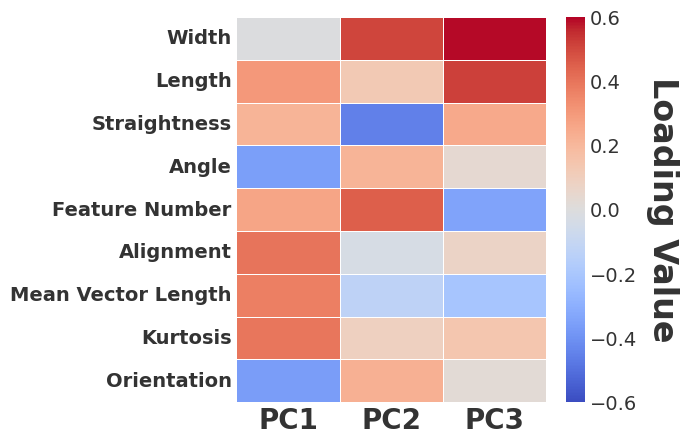

In [24]:
plt.figure(figsize = (5,5))
ax = sns.heatmap(df_loadings, cmap = 'coolwarm', vmin = -0.6, vmax = 0.6,
                 linewidth =0.5, linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), size = 20, rotation = 0,
                   rotation_mode = 'anchor', ha = 'center', weight = 'bold',
                   color = '0.2')
ax.set_yticklabels(ax.get_yticklabels(), size = font_size, rotation = 0,
                   rotation_mode = 'anchor', weight = 'bold',
                   color = '0.2')

# Adjust colorbar tick font size (color range labels)
colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([-0.5, 0, 0.5])
colorbar.ax.tick_params(labelsize=font_size, length = 0)
colorbar_ylabel = colorbar.ax.get_yticklabels()
colorbar.ax.set_yticklabels(colorbar_ylabel, size = font_size, rotation = 0,
                   rotation_mode = 'anchor',
                   color = '0.2')
# Add colorbar label
# Add horizontal colorbar label with extra padding
colorbar.set_label("Loading Value",
                   size=24,
                   weight='bold',
                   color='0.2',
                   rotation=-90,
                   labelpad=30,   # 🔹 increase spacing from bar
                   ha='center')   # 🔹 center it


# Remove tick marks but keep tick labels
ax.tick_params(axis='both', length=0)

# ax.set_title("PCA Loadings", size = 20, weight = 'bold', color = '0.2')

plt.savefig("PCA_Heatmap.png", bbox_inches='tight', dpi=600,
            facecolor=ax.get_facecolor())

In [25]:
# convert series to df
df_pc1Loading = pc1_loading_series.reset_index()
df_pc1Loading.columns = ['Feature', 'Loading']
df_pc2Loading = pc2_loading_series.reset_index()
df_pc2Loading.columns = ['Feature', 'Loading']
df_pc3Loading = pc3_loading_series.reset_index()
df_pc3Loading.columns = ['Feature', 'Loading']

print(df_pc1Loading)

        Feature   Loading
0         Width -0.004861
1        Length  0.300705
2  Straightness  0.212840
3         Angle -0.358558
4     FeatNumCT  0.266554
5     FeatNumCA  0.276212
6   AlignmentCA  0.402011
7   AlignmentMF  0.372076
8      Kurtosis  0.396863
9   Orientation -0.361650


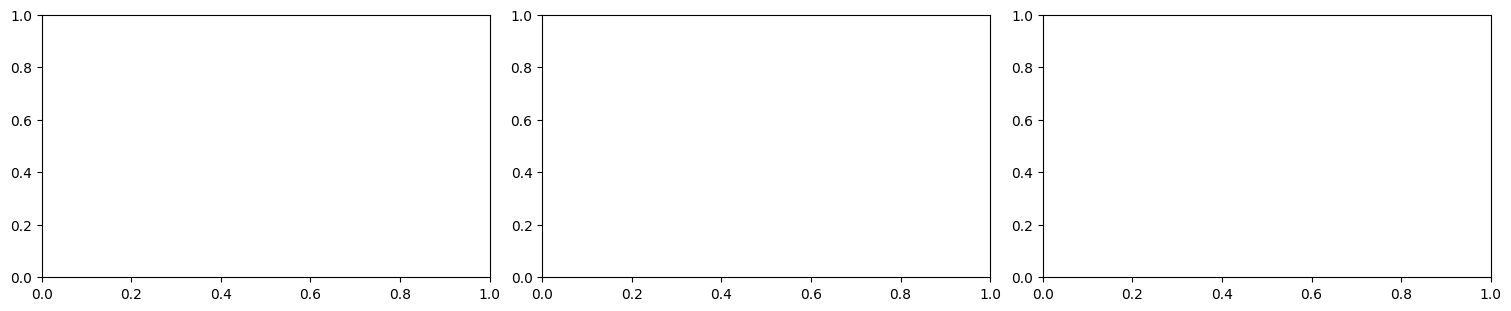

In [26]:
# create panel for PCA Loadings
fig, axes = plt.subplots(1,3,figsize = (15,3), constrained_layout=True)

# x and y label font size
font_size = 16

In [27]:
# pc1 loading plot
plt.figure(figsize=(5, 3))
ax = axes[0]
# custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"]
ax = sns.barplot(data=df_pc1Loading, x='Feature', y='Loading',
                     palette = "OrRd", ax = ax)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
  ax.spines[axis].set_linewidth(2.5)
  ax.spines[axis].set_color('0.2')

# hide top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set y ticks
# ax.set_yticks([-4, -2, 0, 2, 4])

# rotate labels
ax.set_xticklabels(ax.get_xticklabels(), size = font_size, rotation = 35,
                   rotation_mode = 'anchor', ha = 'right', weight = 'bold',
                   color = '0.2')
ax.set_xlabel(None)
ax.set_yticklabels(ax.get_yticklabels(), size = font_size, weight = 'bold', color = '0.2')
ax.set_ylabel("Loading", size = font_size, weight = 'bold', color = '0.2', family = "Arial")

# set title
ax.set_title("PC1", size = font_size, weight = 'bold', color = '0.2')

/tmp/ipython-input-1583791929.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_pc1Loading, x='Feature', y='Loading',
/tmp/ipython-input-1583791929.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size = font_size, rotation = 35,
/tmp/ipython-input-1583791929.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size = font_size, weight = 'bold', color = '0.2')


Text(0.5, 1.0, 'PC1')

<Figure size 500x300 with 0 Axes>

In [28]:
# PC2 loading plot
plt.figure(figsize=(5, 3))
ax_2 = axes[1]
custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"]
ax_2 = sns.barplot(data=df_pc2Loading, x='Feature', y='Loading',
                   palette=custom_palette, ax=ax_2)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
    ax_2.spines[axis].set_linewidth(2.5)
    ax_2.spines[axis].set_color('0.2')

# hide top and right axes
ax_2.spines['top'].set_visible(False)
ax_2.spines['right'].set_visible(False)

# rotate x-axis labels
ax_2.set_xticklabels(ax_2.get_xticklabels(), size=font_size, rotation=35,
                     rotation_mode='anchor', ha='right', weight='bold',
                     color='0.2')

# format y-axis
ax_2.set_xlabel(None)
ax_2.set_yticklabels(ax_2.get_yticklabels(), size=font_size, weight='bold', color='0.2')
ax_2.set_ylabel("Loading", size=font_size, weight='bold', color='0.2')

# set title
ax_2.set_title("PC2", size=font_size, weight='bold', color='0.2')

/tmp/ipython-input-3058606587.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_2 = sns.barplot(data=df_pc2Loading, x='Feature', y='Loading',
/tmp/ipython-input-3058606587.py:5: UserWarning: 
The palette list has fewer values (4) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax_2 = sns.barplot(data=df_pc2Loading, x='Feature', y='Loading',
/tmp/ipython-input-3058606587.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_2.set_xticklabels(ax_2.get_xticklabels(), size=font_size, rotation=35,
/tmp/ipython-input-3058606587.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_2.set_yticklabels(ax_2.get_yticklabels(), size=font_size, weight='bold',

Text(0.5, 1.0, 'PC2')

<Figure size 500x300 with 0 Axes>

In [29]:
# PC3 loading plot
plt.figure(figsize=(5, 3))
ax_3 = axes[2]
custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"]
ax_3 = sns.barplot(data=df_pc3Loading, x='Feature', y='Loading',
                   palette=custom_palette, ax=ax_3)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
    ax_3.spines[axis].set_linewidth(2.5)
    ax_3.spines[axis].set_color('0.2')

# hide top and right axes
ax_3.spines['top'].set_visible(False)
ax_3.spines['right'].set_visible(False)

# rotate x-axis labels
ax_3.set_xticklabels(ax_3.get_xticklabels(), size=font_size, rotation=35,
                     rotation_mode='anchor', ha='right', weight='bold',
                     color='0.2')

# format y-axis
ax_3.set_xlabel(None)
ax_3.set_yticklabels(ax_3.get_yticklabels(), size=font_size, weight='bold', color='0.2')
ax_3.set_ylabel("Loading", size=font_size, weight='bold', color='0.2')

# set title
ax_3.set_title("PC3", size=font_size, weight='bold', color='0.2')

# save figure
fig.savefig("PCA_Loadings.png", bbox_inches='tight', dpi=600,
            facecolor=ax_3.get_facecolor())

/tmp/ipython-input-3295464942.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_3 = sns.barplot(data=df_pc3Loading, x='Feature', y='Loading',
/tmp/ipython-input-3295464942.py:5: UserWarning: 
The palette list has fewer values (4) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax_3 = sns.barplot(data=df_pc3Loading, x='Feature', y='Loading',
/tmp/ipython-input-3295464942.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_3.set_xticklabels(ax_3.get_xticklabels(), size=font_size, rotation=35,
/tmp/ipython-input-3295464942.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_3.set_yticklabels(ax_3.get_yticklabels(), size=font_size, weight='bold',

<Figure size 500x300 with 0 Axes>

In [30]:
# add meta data back to df_grouped
combined_df = pd.concat([meta_df, df_grouped], axis=1)
print(combined_df)

# create new df for PCA data
pca_df = pd.DataFrame(x_pca, columns = ['PC1', 'PC2', 'PC3'])
pca_df['Condition'] = combined_df['Condition_Encoded']

# map original conditions back to encoded condition
name_map = {
    0: 'Acellular',
    1: 'MSC',
    2: 'Pixel Graft',
    3: 'Splint'
}

pca_df['Condition'] = pca_df['Condition'].map(name_map)
print(pca_df)

    Replicate  Condition_Encoded     Width     Length  Straightness  \
0          46                  1  0.882880   7.529280      0.944000   
1          47                  0  0.838431   7.603108      0.947692   
2          48                  2  0.823360   6.767920      0.936000   
3          49                  3  0.838240   8.698600      0.948000   
4          50                  1  0.844750   7.215250      0.950000   
5          51                  1  0.837000   7.703500      0.947500   
6          52                  2  0.870480   8.164160      0.952000   
7          53                  3  0.855600   8.667600      0.950000   
8          54                  3  0.784300   7.322200      0.952500   
9          55                  3  0.830800  10.409800      0.955000   
10         56                  0  0.841429   7.576400      0.952857   
11         57                  0  0.793600   6.770400      0.957500   
12         58                  2  0.871543   7.032571      0.945714   
13    

In [31]:
percentage_pca = pca.explained_variance_ratio_*100
print(percentage_pca)

[54.29538527 22.87261337  8.71618855]


In [32]:
# x and y label font size
font_size = 20

from matplotlib import font_manager as fm

arial_path = '/content/arial.ttf'
arial_prop = fm.FontProperties(fname=arial_path)

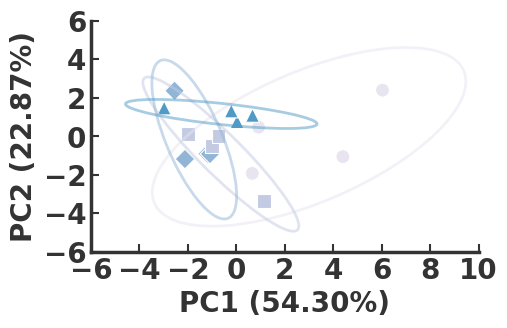

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# Custom palette and markers
custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"]  # light --> dark
desired_order = ['Splint', 'Acellular', 'MSC', 'Pixel Graft']
custom_markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle

plt.figure(figsize=(5, 3))
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette=custom_palette,
                     hue='Condition', style='Condition', hue_order=desired_order,
                     s=100, style_order=desired_order, markers=custom_markers,
                     legend=False)

def draw_ellipse(x, y, ax, edgecolor, confidence=0.95):
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)

    # Eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # Chi-square quantile for the confidence level and 2 DOF
    chi2_val = chi2.ppf(confidence, df=2)

    # Width and height of ellipse (2* because Ellipse width/height are full lengths)
    width, height = 2 * np.sqrt(eigvals * chi2_val)

    # Angle of ellipse rotation in degrees
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

    # Create and add ellipse patch
    ell = Ellipse(xy=(mean_x, mean_y), width=width, height=height, angle=angle,
                  edgecolor=edgecolor, fc='none', lw=2, alpha=0.5)
    ax.add_patch(ell)

# Draw 95% confidence ellipses for each condition using custom_palette colors
draw_ellipse(pca_df[pca_df['Condition'] == 'Splint']['PC1'],
             pca_df[pca_df['Condition'] == 'Splint']['PC2'], ax, edgecolor=custom_palette[0])
draw_ellipse(pca_df[pca_df['Condition'] == 'Acellular']['PC1'],
             pca_df[pca_df['Condition'] == 'Acellular']['PC2'], ax, edgecolor=custom_palette[1])
draw_ellipse(pca_df[pca_df['Condition'] == 'MSC']['PC1'],
             pca_df[pca_df['Condition'] == 'MSC']['PC2'], ax, edgecolor=custom_palette[2])
draw_ellipse(pca_df[pca_df['Condition'] == 'Pixel Graft']['PC1'],
             pca_df[pca_df['Condition'] == 'Pixel Graft']['PC2'], ax, edgecolor=custom_palette[3])

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make bottom and left spines thicker and darker
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

# Put ticks inside the plot area
ax.tick_params(axis='both', direction='in', length=6, width=1.5, colors='0.2', top=False, right=False)

# Set tick label font size, weight, and color
plt.xticks(size=font_size, weight='bold', color='0.2')
plt.yticks(size=font_size, weight='bold', color='0.2')

# Set axis labels with percentage of variance explained
ax.set_xlabel(f"PC1 ({percentage_pca[0]:.2f}%)", size=font_size, weight='bold', color='0.2')
ax.set_ylabel(f"PC2 ({percentage_pca[1]:.2f}%)", size=font_size, weight='bold', color='0.2')

# Set y-limits and ticks
ax.set_ylim(top=pca_df['PC2'].max() + 2)
ax.set_yticks([-6, -4, -2, 0, 2, 4, 6])
ax.set_xticks([-6, -4, -2, 0, 2, 4, 6, 8, 10])

# Optional legend customization (uncomment if needed)
"""
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.5), frameon=True)
for text in legend.get_texts():
    text.set_color('0.2')
    text.set_weight('bold')
    text.set_size(font_size)
"""

# Save figure
plt.savefig('PCA_1v2.png', bbox_inches='tight', dpi=600, facecolor=ax.get_facecolor())
plt.show()

/tmp/ipython-input-1073141314.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax_leg.legend(handles=handles, labels=labels, loc='center',


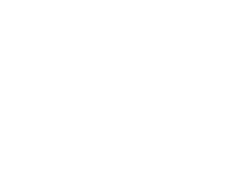

In [34]:
# define handles and labels
handles, labels = ax.get_legend_handles_labels()

# Create new figure and axis for legend
fig_leg = plt.figure(figsize=(3, 2))
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis('off')

# Create legend
legend = ax_leg.legend(handles=handles, labels=labels, loc='center',
                       frameon=False, fontsize=font_size, markerscale = 2)

# Style legend text
for text in legend.get_texts():
    text.set_color('0.2')
    text.set_weight('bold')
    text.set_fontsize(font_size)

# Save legend as separate image
fig_leg.savefig("legend_only.png", bbox_inches='tight', dpi=600, transparent=True)

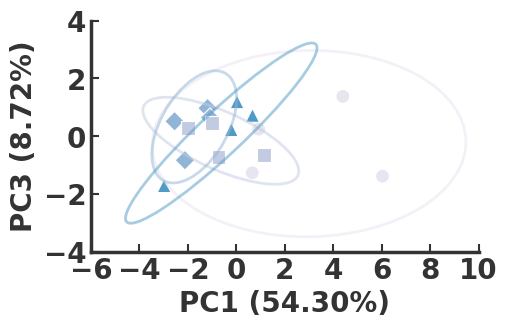

In [35]:
# plot PCA 1v3
custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"]  # light --> dark
desired_order = ['Splint', 'Acellular', 'MSC', 'Pixel Graft']
custom_markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle

plt.figure(figsize=(5, 3))
ax_2 = sns.scatterplot(
    data=pca_df, x='PC1', y='PC3',
    palette=custom_palette, hue='Condition', style='Condition',
    hue_order=desired_order, style_order=desired_order,
    markers=custom_markers, s=100, legend=False
)

import numpy as np
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def draw_ellipse(x, y, ax, edgecolor, confidence=0.95):
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)

    # Eigen decomposition of covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # Chi-square quantile for 2D and given confidence level
    chi2_val = chi2.ppf(confidence, df=2)

    # Width and height of ellipse (full length)
    width, height = 2 * np.sqrt(eigvals * chi2_val)

    # Angle in degrees from eigenvectors
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

    # Create ellipse patch
    ell = Ellipse(
        xy=(mean_x, mean_y),
        width=width,
        height=height,
        angle=angle,
        edgecolor=edgecolor,
        fc='none',
        lw=2,
        alpha=0.5
    )
    ax.add_patch(ell)

# Draw ellipses for PC1 vs PC3 on ax_2
draw_ellipse(pca_df[pca_df['Condition'] == 'Splint']['PC1'],
             pca_df[pca_df['Condition'] == 'Splint']['PC3'], ax_2, edgecolor=custom_palette[0])
draw_ellipse(pca_df[pca_df['Condition'] == 'Acellular']['PC1'],
             pca_df[pca_df['Condition'] == 'Acellular']['PC3'], ax_2, edgecolor=custom_palette[1])
draw_ellipse(pca_df[pca_df['Condition'] == 'MSC']['PC1'],
             pca_df[pca_df['Condition'] == 'MSC']['PC3'], ax_2, edgecolor=custom_palette[2])
draw_ellipse(pca_df[pca_df['Condition'] == 'Pixel Graft']['PC1'],
             pca_df[pca_df['Condition'] == 'Pixel Graft']['PC3'], ax_2, edgecolor=custom_palette[3])


# remove top and right axes
ax_2.spines['top'].set_visible(False)
ax_2.spines['right'].set_visible(False)

# style remaining axes
for axis in ['bottom', 'left']:
    ax_2.spines[axis].set_linewidth(2.5)
    ax_2.spines[axis].set_color('0.2')

# set tick styles
plt.xticks(size=font_size, weight='bold', color='0.2')
plt.yticks(size=font_size, weight='bold', color='0.2')

# axis labels
ax_2.set_xlabel(f"PC1 ({percentage_pca[0]:.2f}%)", size=font_size, weight='bold', color='0.2')
ax_2.set_ylabel(f"PC3 ({percentage_pca[2]:.2f}%)", size=font_size, weight='bold', color='0.2')

# custom ticks
ax_2.set_yticks([-4, -2, 0, 2, 4])
ax_2.set_xticks([-6, -4, -2, 0, 2, 4, 6, 8, 10])

# Put ticks inside the plot area
ax_2.tick_params(axis='both', direction='in', length=6, width=1.5, colors='0.2', top=False, right=False)

# save figure
plt.savefig('PCA_1v3.png', bbox_inches='tight', dpi=600,
            facecolor=ax_2.get_facecolor())

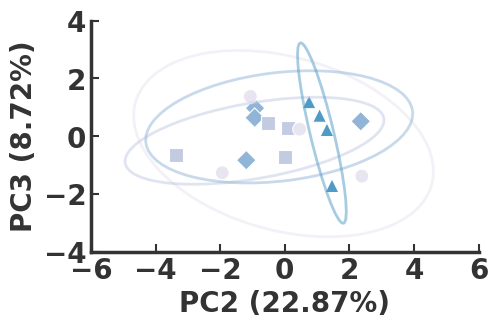

In [36]:
# plot PCA 2v3
custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"]  # light --> dark
desired_order = ['Splint', 'Acellular', 'MSC', 'Pixel Graft']
custom_markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle

plt.figure(figsize=(5, 3))
ax_3 = sns.scatterplot(
    data=pca_df, x='PC2', y='PC3',
    palette=custom_palette, hue='Condition', style='Condition',
    hue_order=desired_order, style_order=desired_order,
    markers=custom_markers, s=100, legend=False
)

import numpy as np
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def draw_ellipse(x, y, ax, edgecolor, confidence=0.95):
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)

    # Eigen decomposition of covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # Chi-square quantile for 2D and confidence level
    chi2_val = chi2.ppf(confidence, df=2)

    # Calculate ellipse width and height (full axes length)
    width, height = 2 * np.sqrt(eigvals * chi2_val)

    # Calculate ellipse rotation angle (in degrees)
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

    # Create and add ellipse patch
    ell = Ellipse(
        xy=(mean_x, mean_y),
        width=width,
        height=height,
        angle=angle,
        edgecolor=edgecolor,
        fc='none',
        lw=2,
        alpha=0.5
    )
    ax.add_patch(ell)

# Draw ellipses on PC2 vs PC3 in ax_3
draw_ellipse(pca_df[pca_df['Condition'] == 'Splint']['PC2'],
             pca_df[pca_df['Condition'] == 'Splint']['PC3'], ax_3, edgecolor="#E8E4F0")
draw_ellipse(pca_df[pca_df['Condition'] == 'Acellular']['PC2'],
             pca_df[pca_df['Condition'] == 'Acellular']['PC3'], ax_3, edgecolor="#C3CBE3")
draw_ellipse(pca_df[pca_df['Condition'] == 'MSC']['PC2'],
             pca_df[pca_df['Condition'] == 'MSC']['PC3'], ax_3, edgecolor="#91B5D6")
draw_ellipse(pca_df[pca_df['Condition'] == 'Pixel Graft']['PC2'],
             pca_df[pca_df['Condition'] == 'Pixel Graft']['PC3'], ax_3, edgecolor="#509AC6")

# remove top and right axes
ax_3.spines['top'].set_visible(False)
ax_3.spines['right'].set_visible(False)

# style remaining axes
for axis in ['bottom', 'left']:
    ax_3.spines[axis].set_linewidth(2.5)
    ax_3.spines[axis].set_color('0.2')

# set tick styles
plt.xticks(size=font_size, weight='bold', color='0.2')
plt.yticks(size=font_size, weight='bold', color='0.2')

# axis labels
ax_3.set_xlabel(f"PC2 ({percentage_pca[1]:.2f}%)", size=font_size, weight='bold', color='0.2')
ax_3.set_ylabel(f"PC3 ({percentage_pca[2]:.2f}%)", size=font_size, weight='bold', color='0.2')

# custom ticks
ax_3.set_yticks([-4, -2, 0, 2, 4])
ax_3.set_xticks([-6, -4, -2, 0, 2, 4, 6])

ax_3.tick_params(axis='both', direction='in', length=6, width=1.5, colors='0.2', top=False, right=False)

# save figure
plt.savefig('PCA_2v3.png', bbox_inches='tight', dpi=600,
            facecolor=ax_3.get_facecolor())